In [2]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#env = gym.make("CarRacing-v0")

# we will directly work from source

In [9]:
# !pip install Box2D-kengz
# !pip install git+https://github.com/pybox2d/pybox2d

In [1]:
import sys
import math

import numpy as np
import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.utils import colorize, seeding, EzPickle

# This is simple 4-joints walker robot environment.
#
# There are two versions:
#
# - Normal, with slightly uneven terrain.
#
# - Hardcore with ladders, stumps, pitfalls.
#
# Reward is given for moving forward, total 300+ points up to the far end. If the robot falls,
# it gets -100. Applying motor torque costs a small amount of points, more optimal agent
# will get better score.
#
# Heuristic is provided for testing, it's also useful to get demonstrations to
# learn from. To run heuristic:
#
# python gym/envs/box2d/bipedal_walker.py
#
# State consists of hull angle speed, angular velocity, horizontal speed, vertical speed,
# position of joints and joints angular speed, legs contact with ground, and 10 lidar
# rangefinder measurements to help to deal with the hardcore version. There's no coordinates
# in the state vector. Lidar is less useful in normal version, but it works.
#
# To solve the game you need to get 300 points in 1600 time steps.
#
# To solve hardcore version you need 300 points in 2000 time steps.
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

FPS    = 50
SCALE  = 30.0   # affects how fast-paced the game is, forces should be adjusted as well

MOTORS_TORQUE = 80
SPEED_HIP     = 4
SPEED_KNEE    = 6
LIDAR_RANGE   = 160/SCALE

INITIAL_RANDOM = 5

HULL_POLY =[
    (-30,+9), (+6,+9), (+34,+1),
    (+34,-8), (-30,-8)
    ]
LEG_DOWN = -8/SCALE
LEG_W, LEG_H = 8/SCALE, 34/SCALE

VIEWPORT_W = 600
VIEWPORT_H = 400

TERRAIN_STEP   = 14/SCALE
TERRAIN_LENGTH = 200     # in steps
TERRAIN_HEIGHT = VIEWPORT_H/SCALE/4
TERRAIN_GRASS    = 10    # low long are grass spots, in steps
TERRAIN_STARTPAD = 20    # in steps
FRICTION = 2.5

HULL_FD = fixtureDef(
                shape=polygonShape(vertices=[ (x/SCALE,y/SCALE) for x,y in HULL_POLY ]),
                density=5.0,
                friction=0.1,
                categoryBits=0x0020,
                maskBits=0x001,  # collide only with ground
                restitution=0.0) # 0.99 bouncy

LEG_FD = fixtureDef(
                    shape=polygonShape(box=(LEG_W/2, LEG_H/2)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)

LOWER_FD = fixtureDef(
                    shape=polygonShape(box=(0.8*LEG_W/2, LEG_H/2)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)

class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        if self.env.hull==contact.fixtureA.body or self.env.hull==contact.fixtureB.body:
            self.env.game_over = True
        for leg in [self.env.legs[1], self.env.legs[3]]:
            if leg in [contact.fixtureA.body, contact.fixtureB.body]:
                leg.ground_contact = True
    def EndContact(self, contact):
        for leg in [self.env.legs[1], self.env.legs[3]]:
            if leg in [contact.fixtureA.body, contact.fixtureB.body]:
                leg.ground_contact = False

class BipedalWalker(gym.Env, EzPickle):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : FPS
    }

    hardcore = False

    def __init__(self):
        EzPickle.__init__(self)
        self.seed()
        self.viewer = None

        self.world = Box2D.b2World()
        self.terrain = None
        self.hull = None

        self.prev_shaping = None

        self.fd_polygon = fixtureDef(
                        shape = polygonShape(vertices=
                        [(0, 0),
                         (1, 0),
                         (1, -1),
                         (0, -1)]),
                        friction = FRICTION)

        self.fd_edge = fixtureDef(
                    shape = edgeShape(vertices=
                    [(0, 0),
                     (1, 1)]),
                    friction = FRICTION,
                    categoryBits=0x0001,
                )

        self.reset()

        high = np.array([np.inf] * 24)
        self.action_space = spaces.Box(np.array([-1, -1, -1, -1]), np.array([1, 1, 1, 1]), dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.terrain: return
        self.world.contactListener = None
        for t in self.terrain:
            self.world.DestroyBody(t)
        self.terrain = []
        self.world.DestroyBody(self.hull)
        self.hull = None
        for leg in self.legs:
            self.world.DestroyBody(leg)
        self.legs = []
        self.joints = []

    def _generate_terrain(self, hardcore):
        GRASS, STUMP, STAIRS, PIT, _STATES_ = range(5)
        state    = GRASS
        velocity = 0.0
        y        = TERRAIN_HEIGHT
        counter  = TERRAIN_STARTPAD
        oneshot  = False
        self.terrain   = []
        self.terrain_x = []
        self.terrain_y = []
        for i in range(TERRAIN_LENGTH):
            x = i*TERRAIN_STEP
            self.terrain_x.append(x)

            if state==GRASS and not oneshot:
                velocity = 0.8*velocity + 0.01*np.sign(TERRAIN_HEIGHT - y)
                if i > TERRAIN_STARTPAD: velocity += self.np_random.uniform(-1, 1)/SCALE   #1
                y += velocity

            elif state==PIT and oneshot:
                counter = self.np_random.randint(3, 5)
                poly = [
                    (x,              y),
                    (x+TERRAIN_STEP, y),
                    (x+TERRAIN_STEP, y-4*TERRAIN_STEP),
                    (x,              y-4*TERRAIN_STEP),
                    ]
                self.fd_polygon.shape.vertices=poly
                t = self.world.CreateStaticBody(
                    fixtures = self.fd_polygon)
                t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                self.terrain.append(t)

                self.fd_polygon.shape.vertices=[(p[0]+TERRAIN_STEP*counter,p[1]) for p in poly]
                t = self.world.CreateStaticBody(
                    fixtures = self.fd_polygon)
                t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                self.terrain.append(t)
                counter += 2
                original_y = y

            elif state==PIT and not oneshot:
                y = original_y
                if counter > 1:
                    y -= 4*TERRAIN_STEP

            elif state==STUMP and oneshot:
                counter = self.np_random.randint(1, 3)
                poly = [
                    (x,                      y),
                    (x+counter*TERRAIN_STEP, y),
                    (x+counter*TERRAIN_STEP, y+counter*TERRAIN_STEP),
                    (x,                      y+counter*TERRAIN_STEP),
                    ]
                self.fd_polygon.shape.vertices=poly
                t = self.world.CreateStaticBody(
                    fixtures = self.fd_polygon)
                t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                self.terrain.append(t)

            elif state==STAIRS and oneshot:
                stair_height = +1 if self.np_random.rand() > 0.5 else -1
                stair_width = self.np_random.randint(4, 5)
                stair_steps = self.np_random.randint(3, 5)
                original_y = y
                for s in range(stair_steps):
                    poly = [
                        (x+(    s*stair_width)*TERRAIN_STEP, y+(   s*stair_height)*TERRAIN_STEP),
                        (x+((1+s)*stair_width)*TERRAIN_STEP, y+(   s*stair_height)*TERRAIN_STEP),
                        (x+((1+s)*stair_width)*TERRAIN_STEP, y+(-1+s*stair_height)*TERRAIN_STEP),
                        (x+(    s*stair_width)*TERRAIN_STEP, y+(-1+s*stair_height)*TERRAIN_STEP),
                        ]
                    self.fd_polygon.shape.vertices=poly
                    t = self.world.CreateStaticBody(
                        fixtures = self.fd_polygon)
                    t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                    self.terrain.append(t)
                counter = stair_steps*stair_width

            elif state==STAIRS and not oneshot:
                s = stair_steps*stair_width - counter - stair_height
                n = s/stair_width
                y = original_y + (n*stair_height)*TERRAIN_STEP

            oneshot = False
            self.terrain_y.append(y)
            counter -= 1
            if counter==0:
                counter = self.np_random.randint(TERRAIN_GRASS/2, TERRAIN_GRASS)
                if state==GRASS and hardcore:
                    state = self.np_random.randint(1, _STATES_)
                    oneshot = True
                else:
                    state = GRASS
                    oneshot = True

        self.terrain_poly = []
        for i in range(TERRAIN_LENGTH-1):
            poly = [
                (self.terrain_x[i],   self.terrain_y[i]),
                (self.terrain_x[i+1], self.terrain_y[i+1])
                ]
            self.fd_edge.shape.vertices=poly
            t = self.world.CreateStaticBody(
                fixtures = self.fd_edge)
            color = (0.3, 1.0 if i%2==0 else 0.8, 0.3)
            t.color1 = color
            t.color2 = color
            self.terrain.append(t)
            color = (0.4, 0.6, 0.3)
            poly += [ (poly[1][0], 0), (poly[0][0], 0) ]
            self.terrain_poly.append( (poly, color) )
        self.terrain.reverse()

    def _generate_clouds(self):
        # Sorry for the clouds, couldn't resist
        self.cloud_poly   = []
        for i in range(TERRAIN_LENGTH//20):
            x = self.np_random.uniform(0, TERRAIN_LENGTH)*TERRAIN_STEP
            y = VIEWPORT_H/SCALE*3/4
            poly = [
                (x+15*TERRAIN_STEP*math.sin(3.14*2*a/5)+self.np_random.uniform(0,5*TERRAIN_STEP),
                 y+ 5*TERRAIN_STEP*math.cos(3.14*2*a/5)+self.np_random.uniform(0,5*TERRAIN_STEP) )
                for a in range(5) ]
            x1 = min( [p[0] for p in poly] )
            x2 = max( [p[0] for p in poly] )
            self.cloud_poly.append( (poly,x1,x2) )

    def reset(self):
        self._destroy()
        self.world.contactListener_bug_workaround = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_bug_workaround
        self.game_over = False
        self.prev_shaping = None
        self.scroll = 0.0
        self.lidar_render = 0

        W = VIEWPORT_W/SCALE
        H = VIEWPORT_H/SCALE

        self._generate_terrain(self.hardcore)
        self._generate_clouds()

        init_x = TERRAIN_STEP*TERRAIN_STARTPAD/2
        init_y = TERRAIN_HEIGHT+2*LEG_H
        self.hull = self.world.CreateDynamicBody(
            position = (init_x, init_y),
            fixtures = HULL_FD
                )
        self.hull.color1 = (0.5,0.4,0.9)
        self.hull.color2 = (0.3,0.3,0.5)
        self.hull.ApplyForceToCenter((self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM), 0), True)

        self.legs = []
        self.joints = []
        for i in [-1,+1]:
            leg = self.world.CreateDynamicBody(
                position = (init_x, init_y - LEG_H/2 - LEG_DOWN),
                angle = (i*0.05),
                fixtures = LEG_FD
                )
            leg.color1 = (0.6-i/10., 0.3-i/10., 0.5-i/10.)
            leg.color2 = (0.4-i/10., 0.2-i/10., 0.3-i/10.)
            rjd = revoluteJointDef(
                bodyA=self.hull,
                bodyB=leg,
                localAnchorA=(0, LEG_DOWN),
                localAnchorB=(0, LEG_H/2),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=MOTORS_TORQUE,
                motorSpeed = i,
                lowerAngle = -0.8,
                upperAngle = 1.1,
                )
            self.legs.append(leg)
            self.joints.append(self.world.CreateJoint(rjd))

            lower = self.world.CreateDynamicBody(
                position = (init_x, init_y - LEG_H*3/2 - LEG_DOWN),
                angle = (i*0.05),
                fixtures = LOWER_FD
                )
            lower.color1 = (0.6-i/10., 0.3-i/10., 0.5-i/10.)
            lower.color2 = (0.4-i/10., 0.2-i/10., 0.3-i/10.)
            rjd = revoluteJointDef(
                bodyA=leg,
                bodyB=lower,
                localAnchorA=(0, -LEG_H/2),
                localAnchorB=(0, LEG_H/2),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=MOTORS_TORQUE,
                motorSpeed = 1,
                lowerAngle = -1.6,
                upperAngle = -0.1,
                )
            lower.ground_contact = False
            self.legs.append(lower)
            self.joints.append(self.world.CreateJoint(rjd))

        self.drawlist = self.terrain + self.legs + [self.hull]

        class LidarCallback(Box2D.b2.rayCastCallback):
            def ReportFixture(self, fixture, point, normal, fraction):
                if (fixture.filterData.categoryBits & 1) == 0:
                    return -1
                self.p2 = point
                self.fraction = fraction
                return fraction
        self.lidar = [LidarCallback() for _ in range(10)]

        return self.step(np.array([0,0,0,0]))[0]

    def step(self, action):
        #self.hull.ApplyForceToCenter((0, 20), True) -- Uncomment this to receive a bit of stability help
        control_speed = False  # Should be easier as well
        if control_speed:
            self.joints[0].motorSpeed = float(SPEED_HIP  * np.clip(action[0], -1, 1))
            self.joints[1].motorSpeed = float(SPEED_KNEE * np.clip(action[1], -1, 1))
            self.joints[2].motorSpeed = float(SPEED_HIP  * np.clip(action[2], -1, 1))
            self.joints[3].motorSpeed = float(SPEED_KNEE * np.clip(action[3], -1, 1))
        else:
            self.joints[0].motorSpeed     = float(SPEED_HIP     * np.sign(action[0]))
            self.joints[0].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[0]), 0, 1))
            self.joints[1].motorSpeed     = float(SPEED_KNEE    * np.sign(action[1]))
            self.joints[1].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[1]), 0, 1))
            self.joints[2].motorSpeed     = float(SPEED_HIP     * np.sign(action[2]))
            self.joints[2].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[2]), 0, 1))
            self.joints[3].motorSpeed     = float(SPEED_KNEE    * np.sign(action[3]))
            self.joints[3].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[3]), 0, 1))

        self.world.Step(1.0/FPS, 6*30, 2*30)

        pos = self.hull.position
        vel = self.hull.linearVelocity

        for i in range(10):
            self.lidar[i].fraction = 1.0
            self.lidar[i].p1 = pos
            self.lidar[i].p2 = (
                pos[0] + math.sin(1.5*i/10.0)*LIDAR_RANGE,
                pos[1] - math.cos(1.5*i/10.0)*LIDAR_RANGE)
            self.world.RayCast(self.lidar[i], self.lidar[i].p1, self.lidar[i].p2)

        state = [
            self.hull.angle,        # Normal angles up to 0.5 here, but sure more is possible.
            2.0*self.hull.angularVelocity/FPS,
            0.3*vel.x*(VIEWPORT_W/SCALE)/FPS,  # Normalized to get -1..1 range
            0.3*vel.y*(VIEWPORT_H/SCALE)/FPS,
            self.joints[0].angle,   # This will give 1.1 on high up, but it's still OK (and there should be spikes on hiting the ground, that's normal too)
            self.joints[0].speed / SPEED_HIP,
            self.joints[1].angle + 1.0,
            self.joints[1].speed / SPEED_KNEE,
            1.0 if self.legs[1].ground_contact else 0.0,
            self.joints[2].angle,
            self.joints[2].speed / SPEED_HIP,
            self.joints[3].angle + 1.0,
            self.joints[3].speed / SPEED_KNEE,
            1.0 if self.legs[3].ground_contact else 0.0
            ]
        state += [l.fraction for l in self.lidar]
        assert len(state)==24

        self.scroll = pos.x - VIEWPORT_W/SCALE/5

        shaping  = 130*pos[0]/SCALE   # moving forward is a way to receive reward (normalized to get 300 on completion)
        shaping -= 5.0*abs(state[0])  # keep head straight, other than that and falling, any behavior is unpunished

        reward = 0
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        for a in action:
            reward -= 0.00035 * MOTORS_TORQUE * np.clip(np.abs(a), 0, 1)
            # normalized to about -50.0 using heuristic, more optimal agent should spend less

        done = False
        if self.game_over or pos[0] < 0:
            reward = -100
            done   = True
        if pos[0] > (TERRAIN_LENGTH-TERRAIN_GRASS)*TERRAIN_STEP:
            done   = True
        return np.array(state), reward, done, {}

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
        self.viewer.set_bounds(self.scroll, VIEWPORT_W/SCALE + self.scroll, 0, VIEWPORT_H/SCALE)

        self.viewer.draw_polygon( [
            (self.scroll,                  0),
            (self.scroll+VIEWPORT_W/SCALE, 0),
            (self.scroll+VIEWPORT_W/SCALE, VIEWPORT_H/SCALE),
            (self.scroll,                  VIEWPORT_H/SCALE),
            ], color=(0.9, 0.9, 1.0) )
        for poly,x1,x2 in self.cloud_poly:
            if x2 < self.scroll/2: continue
            if x1 > self.scroll/2 + VIEWPORT_W/SCALE: continue
            self.viewer.draw_polygon( [(p[0]+self.scroll/2, p[1]) for p in poly], color=(1,1,1))
        for poly, color in self.terrain_poly:
            if poly[1][0] < self.scroll: continue
            if poly[0][0] > self.scroll + VIEWPORT_W/SCALE: continue
            self.viewer.draw_polygon(poly, color=color)

        self.lidar_render = (self.lidar_render+1) % 100
        i = self.lidar_render
        if i < 2*len(self.lidar):
            l = self.lidar[i] if i < len(self.lidar) else self.lidar[len(self.lidar)-i-1]
            self.viewer.draw_polyline( [l.p1, l.p2], color=(1,0,0), linewidth=1 )

        for obj in self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans*f.shape.pos)
                    self.viewer.draw_circle(f.shape.radius, 30, color=obj.color1).add_attr(t)
                    self.viewer.draw_circle(f.shape.radius, 30, color=obj.color2, filled=False, linewidth=2).add_attr(t)
                else:
                    path = [trans*v for v in f.shape.vertices]
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        flagy1 = TERRAIN_HEIGHT
        flagy2 = flagy1 + 50/SCALE
        x = TERRAIN_STEP*3
        self.viewer.draw_polyline( [(x, flagy1), (x, flagy2)], color=(0,0,0), linewidth=2 )
        f = [(x, flagy2), (x, flagy2-10/SCALE), (x+25/SCALE, flagy2-5/SCALE)]
        self.viewer.draw_polygon(f, color=(0.9,0.2,0) )
        self.viewer.draw_polyline(f + [f[0]], color=(0,0,0), linewidth=2 )

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

class BipedalWalkerHardcore(BipedalWalker):
    hardcore = True


In [4]:
# #default policy example
# if __name__=="__main__":
#     # Heurisic: suboptimal, have no notion of balance.
#     env = BipedalWalker()
#     env.reset()
#     steps = 0
#     total_reward = 0
#     a = np.array([0.0, 0.0, 0.0, 0.0])
#     STAY_ON_ONE_LEG, PUT_OTHER_DOWN, PUSH_OFF = 1,2,3
#     SPEED = 0.29  # Will fall forward on higher speed
#     state = STAY_ON_ONE_LEG
#     moving_leg = 0
#     supporting_leg = 1 - moving_leg
#     SUPPORT_KNEE_ANGLE = +0.1
#     supporting_knee_angle = SUPPORT_KNEE_ANGLE
#     while True:
#         s, r, done, info = env.step(a)
#         total_reward += r
#         if steps % 20 == 0 or done:
#             print("\naction " + str(["{:+0.2f}".format(x) for x in a]))
#             print("step {} total_reward {:+0.2f}".format(steps, total_reward))
#             print("hull " + str(["{:+0.2f}".format(x) for x in s[0:4] ]))
#             print("leg0 " + str(["{:+0.2f}".format(x) for x in s[4:9] ]))
#             print("leg1 " + str(["{:+0.2f}".format(x) for x in s[9:14]]))
#         steps += 1

#         contact0 = s[8]
#         contact1 = s[13]
#         moving_s_base = 4 + 5*moving_leg
#         supporting_s_base = 4 + 5*supporting_leg

#         hip_targ  = [None,None]   # -0.8 .. +1.1
#         knee_targ = [None,None]   # -0.6 .. +0.9
#         hip_todo  = [0.0, 0.0]
#         knee_todo = [0.0, 0.0]

#         if state==STAY_ON_ONE_LEG:
#             hip_targ[moving_leg]  = 1.1
#             knee_targ[moving_leg] = -0.6
#             supporting_knee_angle += 0.03
#             if s[2] > SPEED: supporting_knee_angle += 0.03
#             supporting_knee_angle = min( supporting_knee_angle, SUPPORT_KNEE_ANGLE )
#             knee_targ[supporting_leg] = supporting_knee_angle
#             if s[supporting_s_base+0] < 0.10: # supporting leg is behind
#                 state = PUT_OTHER_DOWN
#         if state==PUT_OTHER_DOWN:
#             hip_targ[moving_leg]  = +0.1
#             knee_targ[moving_leg] = SUPPORT_KNEE_ANGLE
#             knee_targ[supporting_leg] = supporting_knee_angle
#             if s[moving_s_base+4]:
#                 state = PUSH_OFF
#                 supporting_knee_angle = min( s[moving_s_base+2], SUPPORT_KNEE_ANGLE )
#         if state==PUSH_OFF:
#             knee_targ[moving_leg] = supporting_knee_angle
#             knee_targ[supporting_leg] = +1.0
#             if s[supporting_s_base+2] > 0.88 or s[2] > 1.2*SPEED:
#                 state = STAY_ON_ONE_LEG
#                 moving_leg = 1 - moving_leg
#                 supporting_leg = 1 - moving_leg

#         if hip_targ[0]: hip_todo[0] = 0.9*(hip_targ[0] - s[4]) - 0.25*s[5]
#         if hip_targ[1]: hip_todo[1] = 0.9*(hip_targ[1] - s[9]) - 0.25*s[10]
#         if knee_targ[0]: knee_todo[0] = 4.0*(knee_targ[0] - s[6])  - 0.25*s[7]
#         if knee_targ[1]: knee_todo[1] = 4.0*(knee_targ[1] - s[11]) - 0.25*s[12]

#         hip_todo[0] -= 0.9*(0-s[0]) - 1.5*s[1] # PID to keep head strait
#         hip_todo[1] -= 0.9*(0-s[0]) - 1.5*s[1]
#         knee_todo[0] -= 15.0*s[3]  # vertical speed, to damp oscillations
#         knee_todo[1] -= 15.0*s[3]

#         a[0] = hip_todo[0]
#         a[1] = knee_todo[0]
#         a[2] = hip_todo[1]
#         a[3] = knee_todo[1]
#         a = np.clip(0.5*a, -1.0, 1.0)

#         env.render()
#         if done: break


In [3]:
env = BipedalWalker()
obs = env.reset()

img = env.render(mode="rgb_array")

C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


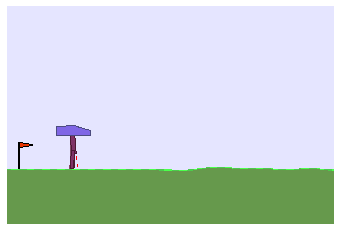

In [5]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
obs

array([ 2.74741068e-03, -1.33236323e-05,  1.03644155e-03, -1.59999073e-02,
        9.19666812e-02, -1.36775302e-03,  8.60266551e-01,  2.41364446e-03,
        1.00000000e+00,  3.23723294e-02, -1.36765209e-03,  8.53815675e-01,
        9.67283190e-04,  1.00000000e+00,  4.40814018e-01,  4.45820123e-01,
        4.61422771e-01,  4.89550203e-01,  5.34102798e-01,  6.02461040e-01,
        7.09148884e-01,  8.85931849e-01,  1.00000000e+00,  1.00000000e+00])

In [7]:
env.action_space

Box(4,)

In [8]:
env.action_space.low

array([-1., -1., -1., -1.], dtype=float32)

In [9]:
env.action_space.high

array([1., 1., 1., 1.], dtype=float32)

In [10]:
# since it is a continuos action space
# we need to discretize it
# for examplewe need to limit the possible torque values
# to 3 values -1.0,0.0,1.0 
# thus we are left with 81 possiblw actions

from itertools import product

possible_torques = np.array([-1.0,0.0,1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

(81, 4)

In [15]:
tf.reset_default_graph()

# the network architecture
n_inputs = env.observation_space.shape[0]
n_hidden = 10
n_outputs = len(possible_actions)
initializer = tf.variance_scaling_initializer()
#Initializer capable of adapting its scale to the shape of weights tensors.

# building the neural network
X = tf.placeholder(tf.float32,shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden,activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden,n_outputs, 
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)


# selecting a random action basedon estimatedprobabilites
action_index = tf.squeeze(tf.multinomial(logits,num_samples=1), axis=-1)

# training
learning_rate = 0.01

y = tf.one_hot(action_index,depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
# trying to run this policy network

def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = BipedalWalker()
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X:obs.reshape(1,n_inputs)})
            action = possible_actions[action_index_val]
            obs , reward, done, info = env.step(action[0])
            if done:
                break
        env.close()
        return frames

In [17]:
from IPython import display
%matplotlib inline

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    for f in frames:
        plt.imshow(f)
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

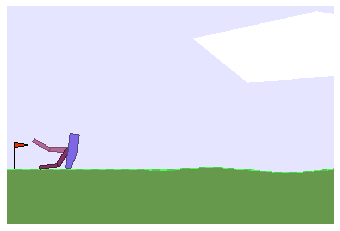

In [23]:
try:
    frames = run_bipedal_walker()
    plot_animation(frames)

except Exception as e:
    print(e)

In [25]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [26]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("Iteration: {}/{}".format(iteration + 1, n_iterations))
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients], feed_dict={X:obs.reshape(1,n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward,done,info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        all_rewards = discount_and_normalize_rewards(all_rewards,discount_rate=discount_rate)
        feed_dict = {}
        for var_index,gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

Iteration: 1/1000
Iteration: 2/1000
Iteration: 3/1000
Iteration: 4/1000
Iteration: 5/1000
Iteration: 6/1000
Iteration: 7/1000
Iteration: 8/1000
Iteration: 9/1000
Iteration: 10/1000
Iteration: 11/1000
Iteration: 12/1000
Iteration: 13/1000
Iteration: 14/1000
Iteration: 15/1000
Iteration: 16/1000
Iteration: 17/1000
Iteration: 18/1000
Iteration: 19/1000
Iteration: 20/1000
Iteration: 21/1000
Iteration: 22/1000
Iteration: 23/1000
Iteration: 24/1000
Iteration: 25/1000
Iteration: 26/1000
Iteration: 27/1000
Iteration: 28/1000
Iteration: 29/1000
Iteration: 30/1000
Iteration: 31/1000
Iteration: 32/1000
Iteration: 33/1000
Iteration: 34/1000
Iteration: 35/1000
Iteration: 36/1000
Iteration: 37/1000
Iteration: 38/1000
Iteration: 39/1000
Iteration: 40/1000
Iteration: 41/1000
Iteration: 42/1000
Iteration: 43/1000
Iteration: 44/1000
Iteration: 45/1000
Iteration: 46/1000
Iteration: 47/1000
Iteration: 48/1000
Iteration: 49/1000
Iteration: 50/1000
Iteration: 51/1000
Iteration: 52/1000
Iteration: 53/1000
It

Iteration: 417/1000
Iteration: 418/1000
Iteration: 419/1000
Iteration: 420/1000
Iteration: 421/1000
Iteration: 422/1000
Iteration: 423/1000
Iteration: 424/1000
Iteration: 425/1000
Iteration: 426/1000
Iteration: 427/1000
Iteration: 428/1000
Iteration: 429/1000
Iteration: 430/1000
Iteration: 431/1000
Iteration: 432/1000
Iteration: 433/1000
Iteration: 434/1000
Iteration: 435/1000
Iteration: 436/1000
Iteration: 437/1000
Iteration: 438/1000
Iteration: 439/1000
Iteration: 440/1000
Iteration: 441/1000
Iteration: 442/1000
Iteration: 443/1000
Iteration: 444/1000
Iteration: 445/1000
Iteration: 446/1000
Iteration: 447/1000
Iteration: 448/1000
Iteration: 449/1000
Iteration: 450/1000
Iteration: 451/1000
Iteration: 452/1000
Iteration: 453/1000
Iteration: 454/1000
Iteration: 455/1000
Iteration: 456/1000
Iteration: 457/1000
Iteration: 458/1000
Iteration: 459/1000
Iteration: 460/1000
Iteration: 461/1000
Iteration: 462/1000
Iteration: 463/1000
Iteration: 464/1000
Iteration: 465/1000
Iteration: 466/1000


Iteration: 827/1000
Iteration: 828/1000
Iteration: 829/1000
Iteration: 830/1000
Iteration: 831/1000
Iteration: 832/1000
Iteration: 833/1000
Iteration: 834/1000
Iteration: 835/1000
Iteration: 836/1000
Iteration: 837/1000
Iteration: 838/1000
Iteration: 839/1000
Iteration: 840/1000
Iteration: 841/1000
Iteration: 842/1000
Iteration: 843/1000
Iteration: 844/1000
Iteration: 845/1000
Iteration: 846/1000
Iteration: 847/1000
Iteration: 848/1000
Iteration: 849/1000
Iteration: 850/1000
Iteration: 851/1000
Iteration: 852/1000
Iteration: 853/1000
Iteration: 854/1000
Iteration: 855/1000
Iteration: 856/1000
Iteration: 857/1000
Iteration: 858/1000
Iteration: 859/1000
Iteration: 860/1000
Iteration: 861/1000
Iteration: 862/1000
Iteration: 863/1000
Iteration: 864/1000
Iteration: 865/1000
Iteration: 866/1000
Iteration: 867/1000
Iteration: 868/1000
Iteration: 869/1000
Iteration: 870/1000
Iteration: 871/1000
Iteration: 872/1000
Iteration: 873/1000
Iteration: 874/1000
Iteration: 875/1000
Iteration: 876/1000


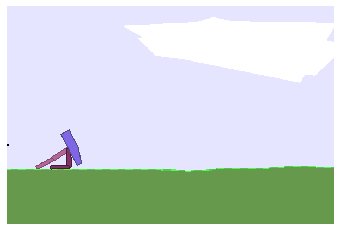

In [ ]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
plt.show()